<a href="https://colab.research.google.com/github/Sandeep0076/Fake-News-Detection-System-for-Covid-19/blob/main/Hybrid_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:

from google.colab import drive
drive.mount("/content/Gdrive")

Mounted at /content/Gdrive


In [ ]:
!pip install transformers~=3.4.0
!pip install boilerpy3
#!pip install transformers
#pip install pytorch-lightning

     |████████████████████████████████| 1.3MB 5.5MB/s 
     |████████████████████████████████| 1.2MB 23.2MB/s 
     |████████████████████████████████| 2.9MB 39.0MB/s 
     |████████████████████████████████| 890kB 36.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=dc868bff4aa69038c466d34275840b7982eb22d5e0b8bd6895a402e7ec8b92f5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
"""## Imports"""
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support as score

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,Dataset,random_split,SubsetRandomSampler

import transformers
from transformers import  BertTokenizer, RobertaModel, BertModel, AdamW, AutoConfig,get_linear_schedule_with_warmup

import time 
from datetime import  date
import warnings
import collections 
from operator import truediv
from boilerpy3 import extractors
from urllib.parse import quote,unquote,urlparse
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup

warnings.filterwarnings('ignore')


In [ ]:
print(f'sklearn version : {sklearn.__version__}')
print(f'torch version : {torch.__version__}')
print(f'transformer version : {transformers.__version__}')
print(f'pandas version : {pd.__version__}')
print(f'numpy version : {np.__version__}')

sklearn version : 0.22.2.post1
torch version : 1.8.0+cu101
transformer version : 3.4.0
pandas version : 1.1.5
numpy version : 1.19.5


In [ ]:
'''
def stratify_train_test(df, stratifyby, *args, **kwargs):
    train, test = pd.DataFrame(), pd.DataFrame()
    gb = df.groupby(stratifyby)
    for k in gb.groups:
        traink, testk = train_test_split(gb.get_group(k), *args, **kwargs)
        train = pd.concat([train, traink])
        test = pd.concat([test, testk])
    return train, test

train, test = stratify_train_test(df1, 'label', test_size=.20)
'''

"\ndef stratify_train_test(df, stratifyby, *args, **kwargs):\n    train, test = pd.DataFrame(), pd.DataFrame()\n    gb = df.groupby(stratifyby)\n    for k in gb.groups:\n        traink, testk = train_test_split(gb.get_group(k), *args, **kwargs)\n        train = pd.concat([train, traink])\n        test = pd.concat([test, testk])\n    return train, test\n\ntrain, test = stratify_train_test(df1, 'label', test_size=.20)\n"

sklearn version : 0.22.2.post1
torch version : 1.7.0+cu101
transformer version : 3.4.0
pandas version : 1.1.4
numpy version : 1.18.5

## Classes

In [ ]:
# Base bert class for training and classification of the model
class Bert_TextClassification_Model(nn.Module):
    def __init__(self):
        super(Bert_TextClassification_Model, self).__init__()
        self.num_classes = NUM_CLASSES
        self.bert_path = 'bert-base-uncased'
        # Adding Gradient checkpoint for reducing memory usage
        #it is saving 50% of memory in my case before the Model was going out of memory even with 11Gb now
        #now after deleting unused variable, checkpointing and smaller variables consuption is reduced to 4Gb
        self.config = AutoConfig.from_pretrained(self.bert_path,
                                                 gradient_checkpointing=True,
                                                 attention_probs_dropout_prob=0.5,
                                                 hidden_dropout_prob=0.5
                                                  )
        #for memory conservation by using smaller value
        self.config.use_bfloat16 = True
        self.bert = transformers.BertModel.from_pretrained(self.bert_path, config=self.config)
        #added a new dropout 
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(768, self.num_classes)

    def forward(self, ids, mask, token_type_ids):
        _, pooled_out = self.bert(
            ids, attention_mask=mask, token_type_ids=token_type_ids)
        #added a new dropout 
        pooled_out = self.dropout(pooled_out)
        return self.out(pooled_out)

# This implements Bert take out the fined tuned model excluding last and add LSTM and linear layer on top of it to achieve higher accuracy
class RoBERT_Model(nn.Module):

    def __init__(self, bertFineTuned):
        super(RoBERT_Model, self).__init__()
        self.num_classes = NUM_CLASSES
        # old model is initialized which is trained and remembers the weights and bais.
        # since bert model only take 512 we will input the data with the same order
        # but before we feed to the lstm layer,we will combine the output of bert which was previously
        # divided into 200, seg and then in last filter out in linear
        self.bertFineTuned = bertFineTuned
        self.lstm = nn.LSTM(768, 100, num_layers=1, bidirectional=False)
        #added a new dropout 
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(100, self.num_classes)

    def forward(self, ids, mask, token_type_ids, num_chunks):
        _, pooled_out = self.bertFineTuned(ids,
                                           attention_mask=mask,
                                           token_type_ids=token_type_ids)

        #For every 200-lenght chunk we extracted a representation vector from BERT of size 768 each
        #which is the size of the hidden layer
        chunks_emb = pooled_out.split_with_sizes(num_chunks)
        #print(f'Number of chunks : {num_chunks}')

        seq_num_chunkshs = torch.LongTensor([x for x in map(len, chunks_emb)])
        #seq_len = tensor(5) for 5 chunks in a document
        del pooled_out
        #  number of 200-num_chunksh chunk is not fixed
        #Pad a list of variable num_chunksh Tensors with padding_value
        #sequences (list[Tensor]) – list of variable num_chunksh sequences.
        #batch_first (bool, optional) – output will be in B x T x * if True, or in T x B x * otherwise
        #padding_value (float, optional) – value for padded elements. Default: 0.
        #* is any number of trailing dimensions
        '''
        , batch size more than one,padding to the max num_chunksh and masking, 
        in this way we pad the shorter sequences with a special value to be masked (skipped for the network) later.
        In this case the special values is -99
        '''
        # batch_emb_pad = [1,5,768]
        batch_emb_pad = nn.utils.rnn.pad_sequence(chunks_emb,
                                                  padding_value=-99,
                                                  batch_first=True)
        # batch_emb = [5,1,768]
        batch_emb = batch_emb_pad.transpose(0, 1)  # (B,L,D) -> (L,B,D)

        #Packs a Tensor containing padded sequences  from above of variable num_chunksh.
        # because each document can be of different len
        lstm_input = nn.utils.rnn.pack_padded_sequence(batch_emb, seq_num_chunkshs.cpu().numpy(),
                                                       batch_first=False, enforce_sorted=False)
        # lstm_input Bactch size is [1,1,1,1,1] meaning 5
        #this will reduce it to 100 layers  as initiatized
        #packed_output = 100*5() 5 is batch
        #h_t = 100 is a  output vector of output shape [1,1,100]
        packed_output, (h_t, h_c) = self.lstm(lstm_input, )  # (h_t, h_c))

        h_t = h_t.view(-1, 100)
        #added dropout
        h_t = self.dropout(h_t)


        return self.out(h_t)

# Train and Evaluate - Bert Model
def train_eval_bert_model(data_loader, model, optimizer, device, mode, scheduler=None):
    target_res = []
    output_res = []
    if mode=='train':
        model.train()
        t0 = time.time()
    elif mode=='eval':
        model.eval()

    else:
        print('wrong mode given')

    losses = []
    for batch_idx, batch in enumerate(data_loader):

        # taking out the data from dataloader
        ids = [data["ids"] for data in batch]
        # This will give list of tensor ids,masks....
        mask = [data["mask"] for data in batch]
        token_type_ids = [data["token_type_ids"] for data in batch]
        targets = [data["targets"] for data in batch]
        # [tensor([1, 1, 1], dtype=torch.int32)]<class 'list'>
        num_chunks = [data['len'] for data in batch]
        #	output is [tensor([3])]<class 'list'>

        # Converting list into tensors
        ids = torch.cat(ids)
        mask = torch.cat(mask)
        token_type_ids = torch.cat(token_type_ids)
        targets = torch.cat(targets)
        # tensor([1, 1, 1], dtype=torch.int32)<class 'torch.Tensor'>
        num_chunks = torch.cat(num_chunks)
        # output is tensor([3])<class 'torch.Tensor'>

        # Loading variables to Memory
        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.long)

        if mode=='train':
            # changing all the previous gradients to zero if any
            optimizer.zero_grad()
            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)

            # Deleting unused variables which consume quite a bit of memory
            del ids, mask, token_type_ids, num_chunks

            loss = loss_fun(outputs, targets)
            loss.backward()
            model.float()
            optimizer.step()
            if scheduler:
                scheduler.step()
            losses.append(loss.item())
            del loss
            if batch_idx % 1000 == 0:
                print(
                    f"batch index = {batch_idx} / {len(data_loader)} ({100 * batch_idx / len(data_loader):.2f}%), loss = {np.mean(losses[-10:]):.4f}, time = {(time.time()-t0)//60} minutes ")
                t0 = time.time()
            output = losses

        elif mode =='eval':
            with torch.no_grad():
                outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
                del ids, mask, token_type_ids, num_chunks
                loss = loss_fun(outputs, targets)
                losses.append(loss.item())
                del loss

            
            target_res.append(targets.cpu().detach().numpy())
            output_res.append(torch.softmax(outputs, dim=1).cpu().detach().numpy())
            output = np.concatenate(output_res), np.concatenate(target_res), losses

    return  output

# Train and Evaluate - RoBert Model
def train_eval_robert_model(data_loader, model, optimizer, device, mode, scheduler=None):
    target_res = []
    output_res = []
    if mode == 'train':
        model.train()
        t0 = time.time()
    elif mode == 'eval':
        model.eval()
    else:
        print('wrong mode given')

    losses = []
    for batch_idx, batch in enumerate(data_loader):

        # taking out the data from dataloader
        ids = [data["ids"] for data in batch]
        mask = [data["mask"] for data in batch]
        token_type_ids = [data["token_type_ids"] for data in batch]
        targets = [data["targets"][0] for data in batch]
        num_chunks = [data['len'] for data in batch]
        # input is <class 'list'>
        # targets and its type : [tensor(0, dtype=torch.int32)]<class 'list'>
        # num_chunks and its type : [tensor([5])]<class 'list'>
        ids = torch.cat(ids)
        mask = torch.cat(mask)
        token_type_ids = torch.cat(token_type_ids)
        targets = torch.stack(targets)
        num_chunks = torch.cat(num_chunks)
        num_chunks = [x.item() for x in num_chunks]
        # stacked targets and its type : tensor([0], dtype=torch.int32)<class 'torch.Tensor'>
        # concatenated num_chunks and its type : tensor([5])<class 'torch.Tensor'>
        # ietms num_chunks and its type : [5]<class 'list'>
        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.long)

        if mode == 'train':
            # changing all the previous gradients to zero if any
            optimizer.zero_grad()
            outputs = model(ids=ids, mask=mask,
                            token_type_ids=token_type_ids, num_chunks=num_chunks)
            del ids, mask, token_type_ids, num_chunks
            loss = loss_fun(outputs, targets)
            loss.backward()
            model.float()
            optimizer.step()
            if scheduler:
                scheduler.step()
            losses.append(loss.item())
            del loss
            if batch_idx % 1000 == 0:
              print(
                f"batch index = {batch_idx} / {len(data_loader)} ({100*batch_idx / len(data_loader):.2f}%), loss = {np.mean(losses[-10:]):.4f}, time = {(time.time()-t0)//60} minutes")
              t0 = time.time()
            target_res.append(targets.cpu().detach().numpy())
            output_res.append(torch.softmax(
                outputs, dim=1).cpu().detach().numpy())
            output = np.concatenate(output_res), np.concatenate(target_res), losses

        elif mode == 'eval':
            with torch.no_grad():
                outputs = model(ids=ids, mask=mask,
                                token_type_ids=token_type_ids, num_chunks=num_chunks)
                loss = loss_fun(outputs, targets)
                losses.append(loss.item())
            target_res.append(targets.cpu().detach().numpy())
            output_res.append(torch.softmax(
                outputs, dim=1).cpu().detach().numpy())
            output = np.concatenate(output_res), np.concatenate(target_res), losses

    return output

# To create a dataloader with variable-size input
def my_collate1(batches):
    return [{key: torch.stack(value) for key, value in batch.items()} for batch in batches]

# Loss function
def loss_fun(outputs, targets):
    loss = nn.CrossEntropyLoss()
    return loss(outputs, targets)
    # return nn.BCEWithLogitsLoss()(outputs, targets)

# For predictions and accuracy
def evaluate(target, predicted):
    true_label_mask = [1 if (np.argmax(x) - target[i]) ==
                            0 else 0 for i, x in enumerate(predicted)]
    nb_prediction = len(true_label_mask)
    true_prediction = sum(true_label_mask)
    false_prediction = nb_prediction - true_prediction
    Accuracy = true_prediction / nb_prediction
    return {
        "Accuracy": Accuracy,
        "No. of examples": len(target),
        "True prediction": true_prediction,
        "False prediction": false_prediction,
    }
#----------------------------------------------
# can join evaluate and f1 score and remove accuracy 

# Precision () is defined as the number of true positives () over 
# the number of true positives plus the number of false positives 
def get_f1_precision_recall(y_test,y_pred):
    
  float_formatter = "{:.2f}".format
  np.set_printoptions(formatter={'float_kind':float_formatter})

  precision, recall, fscore, support = score(y_test, y_pred)
  print('precision: {}'.format(precision))
  print('recall   : {}'.format(recall))
  print('fscore   : {}'.format(fscore))
  return

# For plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# To create, clean and divide the dataset into chunks
class FakeNewsDataset(Dataset):

    def __init__(self, tokenizer, max_len, chunk_len=200, overlap_len=50, max_size_dataset=None,
                  file_location=None, min_len=10, mode='train_eval', testdf=None):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.overlap_len = overlap_len
        self.chunk_len = chunk_len
        self.min_len = min_len
        self.max_size_dataset = max_size_dataset
        self.testdf = testdf
        self.mode = mode
        self.data, self.label,self.label_count,self.label_mapping= self.process_data(file_location,mode,testdf )

    def process_data(self,file_location,mode,testdf):
        
        base_l = []
        # dataset for training and evaluation
        if mode == 'train_eval':
          df = pd.read_csv(file_location)
          train_raw = df[df.body.notnull()]
          train_raw = train_raw[train_raw.title.notnull()]
        # dataset for predicting the single outcome
        elif mode == 'test':
          train_raw = testdf.copy()

        
        base_l = get_base_url (train_raw.url)
        train_raw['base_url'] = base_l
        train_raw = train_raw.assign(len_txt=train_raw.body.apply(lambda x: len(x.split())))
        train_raw = train_raw[train_raw.len_txt > self.min_len]

        train_raw = train_raw[['title','body', 'label','base_url']]
        train_raw.reset_index(inplace=True, drop=True)        
        train = train_raw.copy()
        del train_raw
        if (self.max_size_dataset):
            train = train.loc[0:self.max_size_dataset, :]
        train = train.reindex(np.random.permutation(train.index))
      
        train['body'] = train.body.apply(self.clean_txt)
        train['title'] = train.title.apply(self.clean_txt)
        train['text'] = train[['title','body']].agg(' '.join, axis=1)

        label_count = train['label'].value_counts()
        LE = LabelEncoder()
        train['label'] = LE.fit_transform(train['label'])
        label_mapping = dict(zip(LE.classes_, range(len(LE.classes_))))

        return train['text'].values, train['label'].values,label_count,label_mapping

    def clean_txt(self, text):
        # Apply regex and clean the data
        text = re.sub("'", "", text)
        text = re.sub("the", "", text)
        text = re.sub("The", "", text)
        text = re.sub("(\\W)+", " ", text)
        text = re.sub(r'[^A-Z-a-z. \d/,]', '', text.lower())
        text = ' '.join(text.split())
        return text

    def long_terms_tokenizer(self, data_tokenize, targets):
        
        input_ids_list = []
        attention_mask_list = []
        token_type_ids_list = []
        targets_list = []

        previous_input_ids = data_tokenize["input_ids"].reshape(-1)
        previous_attention_mask = data_tokenize["attention_mask"].reshape(-1)
        previous_token_type_ids = data_tokenize["token_type_ids"].reshape(-1)

        # it contains tokens that are after 200 num_chunksh because of CHUNK_LEN=200
        overflowing_ids = data_tokenize.get("overflowing_tokens").reshape(-1)  # added .reshape(-1)
        targets = torch.tensor(targets, dtype=torch.int)

        input_ids_list.append(previous_input_ids)
        attention_mask_list.append(previous_attention_mask)
        token_type_ids_list.append(previous_token_type_ids)
        targets_list.append(targets)

        if overflowing_ids.nelement() != 0 :
            overflowing_ids = torch.tensor(overflowing_ids, dtype=torch.long)
            # total no. of index, chunck + overflow
            # range means how many steps of 200 chunks eg if len is 723, then range is 4
            idxs = range(len(overflowing_ids) + self.chunk_len)
            # from where the next chunk starts
            # idxs = start, step, stop, 148,148,396
            idxs = idxs[(self.chunk_len - self.overlap_len - 2)
                        ::(self.chunk_len - self.overlap_len - 2)]
            # input_ids_first_overlap last 50 tokens of the first 200 batch
            input_ids_first_overlap = previous_input_ids[-(
                    self.overlap_len + 1):-1]
            start_token = torch.tensor([101], dtype=torch.long)
            end_token = torch.tensor([102], dtype=torch.long)

            for i, idx in enumerate(idxs):
                # enumerate i = counter, 1,2 3--
                if i == 0:
                    # input_ids = 50 from last of the first batch + 148 from overflowing_ids + 2 tokens
                    input_ids = torch.cat(
                        (input_ids_first_overlap, overflowing_ids[:idx]))
                elif i == len(idxs):
                    # for the last overflowing_idsing indexes
                    input_ids = overflowing_ids[idx:]
                elif previous_idx >= len(overflowing_ids):
                    # when the indexes finishes it breaks
                    break
                else:
                    # if not the first and the last, in between then last index-50, to overlap till next 150
                    input_ids = overflowing_ids[(previous_idx - self.overlap_len):idx]

                previous_idx = idx

                # after getting input ids add equivalant amount of attention mask and then token ids
                nb_token = len(input_ids) + 2
                attention_mask = torch.ones(self.chunk_len, dtype=torch.long)  # chunk len = 200
                attention_mask[nb_token:self.chunk_len] = 0
                token_type_ids = torch.zeros(self.chunk_len, dtype=torch.long)
                input_ids = torch.cat((start_token, input_ids, end_token))
                # if its input id is less then 200, then add padding till 200
                if self.chunk_len - nb_token > 0:
                    padding = torch.zeros(
                        self.chunk_len - nb_token, dtype=torch.long)
                    input_ids = torch.cat((input_ids, padding))

                input_ids_list.append(input_ids)
                attention_mask_list.append(attention_mask)
                token_type_ids_list.append(token_type_ids)
                targets_list.append(targets)
        return ({
            'ids': input_ids_list,  # torch.tensor(ids, dtype=torch.long),
            # torch.tensor(mask, dtype=torch.long),
            'mask': attention_mask_list,
            # torch.tensor(token_type_ids, dtype=torch.long),
            'token_type_ids': token_type_ids_list,
            'targets': targets_list,
            'len': [torch.tensor(len(targets_list), dtype=torch.long)]
        })

    def __getitem__(self, idx):

        body = str(self.data[idx])
        targets = int(self.label[idx])
        data = self.tokenizer.encode_plus(
            body,
            truncation=True,
            max_length=self.chunk_len,
            padding='longest',
            add_special_tokens=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_overflowing_tokens=True,
            return_tensors='pt')
        # calling third function
        long_token = self.long_terms_tokenizer(data, targets)
        return long_token

    def __len__(self):
        """ Return data length """
        return self.label.shape[0]

# For extracting base url from complete url
def get_base_url (long_url):  
  ls = []
  for item in long_url:
      u=unquote(item)
      g=urlparse(u)
      base_url=g.netloc
      ls.append(base_url)
  return ls

# For extracting article from the URL 
def get_text_from_url(url):
  try:
    extractor = extractors.ArticleExtractor()
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36'
    }
    resp = requests.get(url, headers=headers)
    if resp.ok:
        doc = extractor.get_content(resp.text)
    else:
        doc = get_body_from_soup(url)
    testarticle = pd.DataFrame(columns=['title','body','label','url']) #header=None
    title = 'news'
    body = doc
    label = 'fake'
    url = url
    testarticle = testarticle.append({'title': title, 'body': body, 'label': label,'url':url}, ignore_index=True)
  except:
    print("Please use different URL")
  return testarticle

#if the above function fails, then use beautiful soup, just a check safe(its not used tho)
def get_body_from_soup(url):
  res = requests.get(url)
  html_page = res.content
  soup = BeautifulSoup(html_page, 'html.parser')
  text = soup.find_all(text=True)
  set([t.parent.name for t in text])
  output = ''
  want = ['body','title','p','div','article','h1','h2','h3','h4']
  for t in text:
      if t.parent.name in want:
          output += '{} '.format(t)
  return output

def predict_article(url,model,model_roberta):
    

  url = url
  testarticle = get_text_from_url(url)
  # Extracting Dataset
  testdataset = FakeNewsDataset(
                            tokenizer=bert_tokenizer,
                            min_len=MIN_LEN,
                            max_len=MAX_LEN,
                            chunk_len=CHUNK_LEN,
                            max_size_dataset=1,
                            overlap_len=OVERLAP_LEN,
                            mode='test',
                            testdf=testarticle
                            )

  test_data_loader=DataLoader(testdataset,
                                batch_size=1,
                                sampler=None,
                                collate_fn=my_collate1)
  num_training_steps = int(len(testdataset) / TRAIN_BATCH_SIZE * EPOCH)
  # Initializing/ loading Bert model trained before
  model = model

  #Loading all the layers of the bert model except the last one as explained in the class above.
  model_roberta = model_robert
  optimizer = AdamW(model_roberta.parameters(), lr=lr)
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps=0,
                                              num_training_steps=num_training_steps)
  val_losses = []
  output, target, val_losses_tmp = train_eval_robert_model(test_data_loader, model_roberta, optimizer, device,'eval')
  y_pred = np.argmax(output, axis=1).flatten()[0] #Estimated targets as returned by a classifier.
  pred_label = dict(map(reversed, dataset.label_mapping.items()))
  
  return pred_label[y_pred]

# Check if Graphic card is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## HyperParameters

In [ ]:
TRAIN_BATCH_SIZE = 1
DATASET_SPLIT = None
shuffle_dataset = True
random_seed = 42
# MIN_LEN=249
MIN_LEN = 10
MAX_LEN = 50
CHUNK_LEN = 200
OVERLAP_LEN = 50
max_size_dataset =None
#max_size_dataset = 200
NUM_CLASSES = 4
lr = 1e-5
file_location1="/content/Gdrive/MyDrive/covid19_news_dataset_train.csv"
file_location2="/content/drive/MyDrive/covid19_news_dataset_test.csv"
# Defining tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#file_location = file_location1

## Preparing Data For Training and validation

In [ ]:
# Extracting Dataset for train_eval
#file_location3="/content/Gdrive/MyDrive/covid19_news_dataset.csv"
dataset = FakeNewsDataset(file_location = file_location1,
                          tokenizer=bert_tokenizer,
                          min_len=MIN_LEN,
                          max_len=MAX_LEN,
                          chunk_len=CHUNK_LEN,
                          max_size_dataset=max_size_dataset,
                          overlap_len=OVERLAP_LEN,
                          mode='train_eval',
                          testdf=None
                          )

dataset_size = len(dataset)
print('Total articles :' + str(dataset_size))


Total articles :28557


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset.label_count


High probability true     13168
High probability fake     12675
fake                       1377
true                       1337
Name: label, dtype: int64

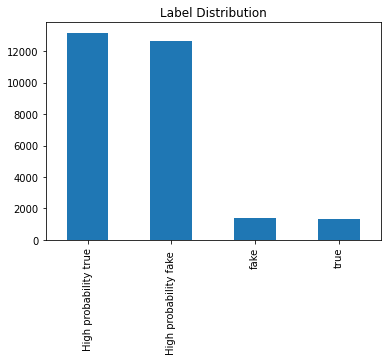

In [ ]:
dataset.label_count.plot.bar()
plt.title('Label Distribution')
plt.show()
#test.groupby(['label']).size()

In [ ]:
# Because the labels are imbalanced, we split the data set in a stratified fashion, using this as the class labels.
#Dividing into Train and Validating

DATASET_SPLIT = .16
train_idx, valid_idx = train_test_split(
                                        np.arange(dataset_size),
                                        test_size=DATASET_SPLIT,
                                        shuffle=True,
                                        stratify=dataset.label)

# Creating data indices for training and validation splits:
#Map-style datasets
#A map-style dataset is one that implements the __getitem__() and __len__() protocols,
# and represents a map from (possibly non-integral) indices/keys to data samples.

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_data_loader=DataLoader(
                              dataset,
                              batch_size=TRAIN_BATCH_SIZE,
                              sampler=train_sampler,
                              collate_fn=my_collate1)

valid_data_loader=DataLoader(
                              dataset,
                              batch_size=TRAIN_BATCH_SIZE,
                              sampler=valid_sampler,
                              collate_fn=my_collate1)


In [ ]:
train_classes = [dataset.label[i] for i in train_sampler.indices]
validation_classes = [dataset.label[i] for i in valid_sampler.indices]
import collections
print(f'Number of labels in Training set are :{collections.Counter(train_classes)}') 
print(f'Number of labels in Validation set are :{collections.Counter(validation_classes)}') 

Number of labels in Training set are :Counter({1: 11061, 0: 10646, 2: 1157, 3: 1123})
Number of labels in Validation set are :Counter({1: 2107, 0: 2029, 2: 220, 3: 214})


## Preparing data For Testing (Done seperately because of some changes in last phase)

In [ ]:
# Extracting Dataset for train_eval
#file_location = file_location2
file_location2 = '/content/Gdrive/MyDrive/covid19_news_dataset_test.csv'
dataset = FakeNewsDataset(file_location=file_location2,
                          tokenizer=bert_tokenizer,
                          min_len=MIN_LEN,
                          max_len=MAX_LEN,
                          chunk_len=CHUNK_LEN,
                          max_size_dataset=max_size_dataset,
                          overlap_len=OVERLAP_LEN,
                          mode='train_eval',
                          testdf=None
                          )

dataset_size = len(dataset)
print('Total articles :' + str(dataset_size))


Total articles :7132


In [ ]:
#print(df.groupby(['label']).size())
testindex = np.arange(len(dataset))
test_sampler = SubsetRandomSampler(testindex)
test_data_loader=DataLoader(
                              dataset,
                              batch_size=1,
                              sampler=test_sampler,
                              collate_fn=my_collate1)


In [ ]:
test_classes = [dataset.label[i] for i in test_sampler.indices]

import collections
print(f'Number of labels in Test set are :{collections.Counter(test_classes)}') 

Number of labels in Test set are :Counter({1: 3293, 0: 3165, 2: 342, 3: 332})


## Train Bert

In [ ]:
# Finetuning Data
EPOCH = 1
today = date.today()
num_training_steps = int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

bert_model = model
#bert_model = Bert_TextClassification_Model().to(device)
# optimizer = SGD(model_hierarchical.parameters(), lr=0.01, momentum=0.9)
optimizer = AdamW(bert_model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=num_training_steps)
val_losses = []
batches_losses = []
val_acc = []
for epoch in range(EPOCH):
    # Training loop----------------------------------
    t0 = time.time()
    print(f"\n \t Training Bert:  EPOCH {epoch + 1} / {EPOCH}\n")
    batches_losses_tmp = train_eval_bert_model(train_data_loader, bert_model, optimizer, device,'train')
    epoch_loss = np.mean(batches_losses_tmp)
    print(
        f"\n \t avg_loss : {epoch_loss:.2f}, time : ~{(time.time() - t0)//3600} hour ({(time.time() - t0)//60} min) \n")
    
    #Evaluation loop---------------------------------
    t1 = time.time()
    output, target, val_losses_tmp = train_eval_bert_model(valid_data_loader, bert_model, optimizer, device, 'eval')
    print(f"\n \t Evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {(time.time() - t1)//60} min \n")
    tmp_evaluate = evaluate(target.reshape(-1), output)

  	
    # Predicting Accuracy-------------------------------
    print(f"\t Accuracy = {tmp_evaluate['Accuracy']} \n \t No. of examples = {tmp_evaluate['No. of examples']}\n"
          f"\t True prediction = {tmp_evaluate['True prediction']} \n \t False prediction = {tmp_evaluate['False prediction']} \n")
  

    val_acc.append(tmp_evaluate['Accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)


    #Saving model-------------------------------------
    print("\t Saving Bert model ")
    torch.save(bert_model.state_dict(), f"/content/Gdrive/My Drive/finetuned_BERT_Model-{today}-{epoch+1}.pt")
  



 	 Training Bert:  EPOCH 1 / 1

batch index = 0 / 28551 (0.00%), loss = 0.1377, time = 0.0 minutes 
batch index = 1000 / 28551 (3.50%), loss = 0.1287, time = 5.0 minutes 
batch index = 2000 / 28551 (7.01%), loss = 0.4291, time = 5.0 minutes 
batch index = 3000 / 28551 (10.51%), loss = 0.5301, time = 5.0 minutes 
batch index = 4000 / 28551 (14.01%), loss = 0.6784, time = 5.0 minutes 
batch index = 5000 / 28551 (17.51%), loss = 0.1869, time = 5.0 minutes 
batch index = 6000 / 28551 (21.02%), loss = 0.3092, time = 5.0 minutes 
batch index = 7000 / 28551 (24.52%), loss = 0.2186, time = 4.0 minutes 
batch index = 8000 / 28551 (28.02%), loss = 0.1023, time = 5.0 minutes 
batch index = 9000 / 28551 (31.52%), loss = 0.4336, time = 5.0 minutes 
batch index = 10000 / 28551 (35.03%), loss = 0.1608, time = 5.0 minutes 
batch index = 11000 / 28551 (38.53%), loss = 0.0734, time = 5.0 minutes 
batch index = 12000 / 28551 (42.03%), loss = 0.3219, time = 5.0 minutes 
batch index = 13000 / 28551 (45.53

## Train BERT-LSTM Hybrid Model


In [ ]:
model = Bert_TextClassification_Model()
model.load_state_dict(torch.load('/content/drive/MyDrive/finetuned_BERT_Model-2021-03-03-1.pt'))
model.to(device)
model.eval()

In [ ]:
# Latest
'''
# commenting this because I am not loading from the saved checkpoint
model = Bert_TextClassification_Model()
model.load_state_dict(torch.load('saved_Bert_Model1.pt'))
model.to(device)
model.eval()
'''
EPOCH = 2
today = date.today()
num_training_steps = int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)
# Initializing/ loading Bert model trained before
model = model

#Loading all the layers of the bert model except the last one as explained in the class above.
#model_roberta = RoBERT_Model(bertFineTuned=list(model.children())[0]).to(device)
model_roberta = model_robert
optimizer = AdamW(model_roberta.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=num_training_steps)
val_losses = []
train_losses = []
batches_losses_train = []
batches_losses_val = []
val_acc = []
train_acc = []
for epoch in range(EPOCH):
    # Training loop----------------------------------
    t0 = time.time()
    print(f"\n \t Training Robert: EPOCH {epoch + 1} / {EPOCH} \n")
    output, target, batches_losses_tmp = train_eval_robert_model(train_data_loader, model_roberta, optimizer, device,'train')
    epoch_loss = np.mean(batches_losses_tmp)
    print(
        f"\n \t avg_loss : {epoch_loss:.2f}, time : ~{(time.time() - t0) // 3600} hour ({(time.time() - t0) // 60} min)\n")
    tmp_evaluate = evaluate(target.reshape(-1), output)

    #Predicting accuracy------------------------------
    print(f"\t Accuracy = {tmp_evaluate['Accuracy']} \n \t No. of examples = {tmp_evaluate['No. of examples']}\n"
          f"\t True prediction = {tmp_evaluate['True prediction']} \n \t False prediction = {tmp_evaluate['False prediction']} \n")

    train_acc.append(tmp_evaluate['Accuracy'])
    train_losses.append(batches_losses_tmp)
    #batches_losses_train.append(batches_losses_tmp)

    
    # Evaluation loop----------------------------------
    t1 = time.time()
    output, target, val_losses_tmp = train_eval_robert_model(valid_data_loader, model_roberta, optimizer, device,'eval')
    print(f"\t  Evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {(time.time() - t1) // 60} min \n")
    tmp_evaluate = evaluate(target.reshape(-1), output)

    #Predicting accuracy------------------------------
    print(f"\t Accuracy = {tmp_evaluate['Accuracy']} \n \t No. of examples = {tmp_evaluate['No. of examples']}\n"
          f"\t True prediction = {tmp_evaluate['True prediction']} \n \t False prediction = {tmp_evaluate['False prediction']} \n")


    val_acc.append(tmp_evaluate['Accuracy'])
    val_losses.append(val_losses_tmp)
    #batches_losses_val.append(batches_losses_tmp)

    # Saving the model
    print("\t Saving Roberta model ")
    #torch.save(model_roberta.state_dict(), f"/content/Gdrive/My Drive/RoBERT_Model-{today}-{epoch+1}.pt")
    torch.save(model_roberta.state_dict(), f"/content/drive/MyDrive/RoBERT_Model-{today}-{epoch+1}.pt")

    # ----------------


 	 Training Robert: EPOCH 1 / 2 

batch index = 0 / 23987 (0.00%), loss = 0.0937, time = 0.0 minutes
batch index = 1000 / 23987 (4.17%), loss = 0.0029, time = 5.0 minutes
batch index = 2000 / 23987 (8.34%), loss = 0.3371, time = 5.0 minutes
batch index = 3000 / 23987 (12.51%), loss = 0.0444, time = 4.0 minutes
batch index = 4000 / 23987 (16.68%), loss = 0.2242, time = 5.0 minutes
batch index = 5000 / 23987 (20.84%), loss = 0.1646, time = 4.0 minutes
batch index = 6000 / 23987 (25.01%), loss = 0.2561, time = 4.0 minutes
batch index = 7000 / 23987 (29.18%), loss = 0.0453, time = 4.0 minutes
batch index = 8000 / 23987 (33.35%), loss = 0.7569, time = 5.0 minutes
batch index = 9000 / 23987 (37.52%), loss = 0.1641, time = 4.0 minutes
batch index = 10000 / 23987 (41.69%), loss = 0.0167, time = 5.0 minutes
batch index = 11000 / 23987 (45.86%), loss = 0.1191, time = 4.0 minutes
batch index = 12000 / 23987 (50.03%), loss = 0.0186, time = 4.0 minutes
batch index = 13000 / 23987 (54.20%), loss = 

In [ ]:
EPOCH = 2
today = date.today()
num_training_steps = int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)
# Initializing/ loading Bert model trained before
model = model

#Loading all the layers of the bert model except the last one as explained in the class above.
#model_roberta = RoBERT_Model(bertFineTuned=list(model.children())[0]).to(device)
model_roberta = model_roberta
optimizer = AdamW(model_roberta.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=num_training_steps)
val_losses = []
train_losses = []
batches_losses_train = []
batches_losses_val = []
val_acc = []
train_acc = []
for epoch in range(EPOCH):
    # Training loop----------------------------------
    t0 = time.time()
    print(f"\n \t Training Robert: EPOCH {epoch + 1} / {EPOCH} \n")
    output, target, batches_losses_tmp = train_eval_robert_model(train_data_loader, model_roberta, optimizer, device,'train')
    epoch_loss = np.mean(batches_losses_tmp)
    print(
        f"\n \t avg_loss : {epoch_loss:.2f}, time : ~{(time.time() - t0) // 3600} hour ({(time.time() - t0) // 60} min)\n")
    tmp_evaluate = evaluate(target.reshape(-1), output)

    #Predicting accuracy------------------------------
    print(f"\t Accuracy = {tmp_evaluate['Accuracy']} \n \t No. of examples = {tmp_evaluate['No. of examples']}\n"
          f"\t True prediction = {tmp_evaluate['True prediction']} \n \t False prediction = {tmp_evaluate['False prediction']} \n")

    train_acc.append(tmp_evaluate['Accuracy'])
    train_losses.append(batches_losses_tmp)
    #batches_losses_train.append(batches_losses_tmp)

    
    # Evaluation loop----------------------------------
    t1 = time.time()
    output, target, val_losses_tmp = train_eval_robert_model(valid_data_loader, model_roberta, optimizer, device,'eval')
    print(f"\t  Evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {(time.time() - t1) // 60} min \n")
    tmp_evaluate = evaluate(target.reshape(-1), output)

    #Predicting accuracy------------------------------
    print(f"\t Accuracy = {tmp_evaluate['Accuracy']} \n \t No. of examples = {tmp_evaluate['No. of examples']}\n"
          f"\t True prediction = {tmp_evaluate['True prediction']} \n \t False prediction = {tmp_evaluate['False prediction']} \n")


    val_acc.append(tmp_evaluate['Accuracy'])
    val_losses.append(val_losses_tmp)
    #batches_losses_val.append(batches_losses_tmp)

    # Saving the model
    print("\t Saving Roberta model ")
    #torch.save(model_roberta.state_dict(), f"/content/Gdrive/My Drive/RoBERT_Model-{today}-{epoch+1}.pt")
    torch.save(model_roberta.state_dict(), f"/content/drive/MyDrive/RoBERT_Model-{today}-{epoch+1}.pt")

    # ----------------



 	 Training Robert: EPOCH 1 / 2 

batch index = 0 / 23987 (0.00%), loss = 1.1341, time = 0.0 minutes
batch index = 1000 / 23987 (4.17%), loss = 1.1864, time = 4.0 minutes
batch index = 2000 / 23987 (8.34%), loss = 0.4006, time = 4.0 minutes
batch index = 3000 / 23987 (12.51%), loss = 0.4653, time = 4.0 minutes
batch index = 4000 / 23987 (16.68%), loss = 0.3271, time = 4.0 minutes
batch index = 5000 / 23987 (20.84%), loss = 0.0322, time = 4.0 minutes
batch index = 6000 / 23987 (25.01%), loss = 0.0134, time = 4.0 minutes
batch index = 7000 / 23987 (29.18%), loss = 0.4176, time = 4.0 minutes
batch index = 8000 / 23987 (33.35%), loss = 0.0195, time = 4.0 minutes
batch index = 9000 / 23987 (37.52%), loss = 0.0334, time = 4.0 minutes
batch index = 10000 / 23987 (41.69%), loss = 0.8658, time = 4.0 minutes
batch index = 11000 / 23987 (45.86%), loss = 0.3532, time = 4.0 minutes
batch index = 12000 / 23987 (50.03%), loss = 0.0369, time = 4.0 minutes
batch index = 13000 / 23987 (54.20%), loss = 

In [ ]:
EPOCH = 2
today = date.today()
num_training_steps = int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)
# Initializing/ loading Bert model trained before
model = model

#Loading all the layers of the bert model except the last one as explained in the class above.
#model_roberta = RoBERT_Model(bertFineTuned=list(model.children())[0]).to(device)
model_roberta = model_robert
optimizer = AdamW(model_roberta.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=num_training_steps)
val_losses = []
train_losses = []
batches_losses_train = []
batches_losses_val = []
val_acc = []
train_acc = []
for epoch in range(EPOCH):
    # Training loop----------------------------------
    t0 = time.time()
    print(f"\n \t Training Robert: EPOCH {epoch + 1} / {EPOCH} \n")
    output, target, batches_losses_tmp = train_eval_robert_model(train_data_loader, model_roberta, optimizer, device,'train')
    epoch_loss = np.mean(batches_losses_tmp)
    print(
        f"\n \t avg_loss : {epoch_loss:.2f}, time : ~{(time.time() - t0) // 3600} hour ({(time.time() - t0) // 60} min)\n")
    tmp_evaluate = evaluate(target.reshape(-1), output)

    #Predicting accuracy------------------------------
    print(f"\t Accuracy = {tmp_evaluate['Accuracy']} \n \t No. of examples = {tmp_evaluate['No. of examples']}\n"
          f"\t True prediction = {tmp_evaluate['True prediction']} \n \t False prediction = {tmp_evaluate['False prediction']} \n")

    train_acc.append(tmp_evaluate['Accuracy'])
    train_losses.append(batches_losses_tmp)
    #batches_losses_train.append(batches_losses_tmp)

    
    # Evaluation loop----------------------------------
    t1 = time.time()
    output, target, val_losses_tmp = train_eval_robert_model(valid_data_loader, model_roberta, optimizer, device,'eval')
    print(f"\t  Evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {(time.time() - t1) // 60} min \n")
    tmp_evaluate = evaluate(target.reshape(-1), output)

    #Predicting accuracy------------------------------
    print(f"\t Accuracy = {tmp_evaluate['Accuracy']} \n \t No. of examples = {tmp_evaluate['No. of examples']}\n"
          f"\t True prediction = {tmp_evaluate['True prediction']} \n \t False prediction = {tmp_evaluate['False prediction']} \n")


    val_acc.append(tmp_evaluate['Accuracy'])
    val_losses.append(val_losses_tmp)
    #batches_losses_val.append(batches_losses_tmp)

    # Saving the model
    print("\t Saving Roberta model ")
    #torch.save(model_roberta.state_dict(), f"/content/Gdrive/My Drive/RoBERT_Model-{today}-{epoch+1}.pt")
    torch.save(model_roberta.state_dict(), f"/content/drive/MyDrive/RoBERT_Model-{today}-{epoch+1}.pt")

    # ----------------



 	 Training Robert: EPOCH 1 / 2 

batch index = 0 / 23987 (0.00%), loss = 0.1761, time = 0.0 minutes
batch index = 1000 / 23987 (4.17%), loss = 0.0142, time = 8.0 minutes
batch index = 2000 / 23987 (8.34%), loss = 0.0863, time = 8.0 minutes
batch index = 3000 / 23987 (12.51%), loss = 0.3922, time = 8.0 minutes
batch index = 4000 / 23987 (16.68%), loss = 0.0592, time = 8.0 minutes
batch index = 5000 / 23987 (20.84%), loss = 0.5011, time = 9.0 minutes
batch index = 6000 / 23987 (25.01%), loss = 0.0210, time = 8.0 minutes
batch index = 7000 / 23987 (29.18%), loss = 0.1459, time = 9.0 minutes
batch index = 8000 / 23987 (33.35%), loss = 0.0202, time = 8.0 minutes
batch index = 9000 / 23987 (37.52%), loss = 0.0080, time = 8.0 minutes
batch index = 10000 / 23987 (41.69%), loss = 0.0624, time = 8.0 minutes
batch index = 11000 / 23987 (45.86%), loss = 0.2910, time = 8.0 minutes
batch index = 12000 / 23987 (50.03%), loss = 0.2967, time = 9.0 minutes
batch index = 13000 / 23987 (54.20%), loss = 

## Check Parameters 

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model_roberta)

## Check Accuracy

In [ ]:
y_pred = np.argmax(output, axis=1).flatten() #Estimated targets as returned by a classifier.
y_test = target #Ground truth (correct) target values.

In [ ]:
dataset.label_count.index

Index(['High probability true', 'High probability fake ', 'fake', 'true'], dtype='object')

Confusion matrix, without normalization


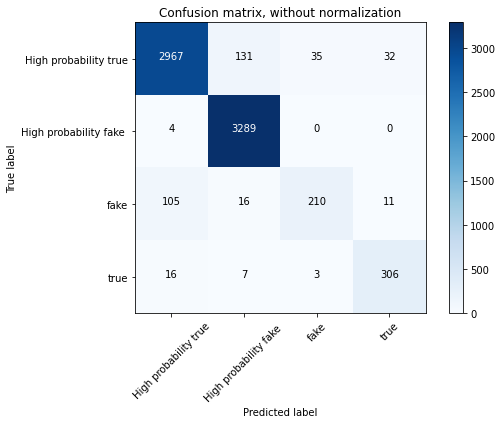

In [ ]:
#calculate confusion matrix
#cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2,3])

#calculate Precision and recall from Conf_matrix
tp = np.diag(cnf_matrix)
prec = list(map(truediv, tp, np.sum(cnf_matrix, axis=0)))
rec = list(map(truediv, tp, np.sum(cnf_matrix, axis=1)))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=dataset.label_count.index,title='Confusion matrix, without normalization')

In [ ]:
get_f1_precision_recall(y_test,y_pred)

precision: [0.96 0.96 0.85 0.88]
recall   : [0.94 1.00 0.61 0.92]
fscore   : [0.95 0.98 0.71 0.90]


## Load Trained Model

In [ ]:
model

In [ ]:
model = Bert_TextClassification_Model()
model.load_state_dict(torch.load('/content/Gdrive/MyDrive/finetuned_BERT_Model-2020-12-14-2.pt'))
model.to(device)
model.eval()
file_location3 = '/content/Gdrive/MyDrive/recovery-news-data.csv'

In [ ]:
model_robert = RoBERT_Model(bertFineTuned=list(model.children())[0]).to(device)
model_robert.load_state_dict(torch.load('/content/Gdrive/MyDrive/RoBERT_Model-2021-02-15-2.pt'))
model_robert.to(device)
model_robert.eval()

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model_robert)

## Predict test data

In [ ]:
url = 'https://www.who.int/news-room/detail/08-04-2020-strengthening-accountability-to-end-tb'

In [ ]:
predict_article(url,model=model,model_roberta=model_robert)